### Warning, work in progress
Trying to get models to actually fit to real-world
data, with very limited success so far.
Here I am exponentiating the random process values.

Possible next steps:
- Make the random walk actually a walk
- Allow for time step other than one (possibly)
- Distinguish infection time from symptom onset time

In [1]:
from typing import Dict, List
from collections import namedtuple
from scipy.stats import gamma
import numpy as np
import pandas as pd
from datetime import datetime
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import minimize, shgo

In [2]:
Outputs = namedtuple('outputs', ['incidence', 'suscept', 'r_t'])

def semimech(gen_time_densities, process_vals, pop, seed, n_times, gen_times_end) -> Outputs:
    """The semimechanistic process.
    """
    incidence = np.zeros(n_times)
    suscept = np.zeros(n_times)
    r_t = np.zeros(n_times)

    incidence[0] = seed
    suscept[0] = pop - seed
    r_t[0] = np.nan
    
    for t in range(1, n_times):

        # Calculations
        gen_times_interest = min(t, gen_times_end)  # Number of generation times relevant to current loop
        inc_vals = incidence[t - gen_times_interest :t]  # Incidence series
        gen_vals = gen_time_densities[:gen_times_interest]  # Generation series
        contribution_by_day = inc_vals * gen_vals[::-1]  # Product of incidence values and reversed generation times
        infect_modifier = process_vals[t] * suscept[t - 1] / pop  # Pre-specified process by the proportion susceptible
        this_inc = contribution_by_day.sum() * infect_modifier  # Incidence for this time point
        this_suscept = max(suscept[t - 1] - this_inc, 0.0)  # Zero out any small negative susceptible values

        # Output tracking
        incidence[t] = this_inc
        suscept[t] = this_suscept
        r_t[t] = gen_vals.sum() * infect_modifier

    return Outputs(incidence, suscept, r_t)

def get_gamma_params_from_mean_sd(req_mean: float, req_sd: float) -> Dict[str, float]:
    """Get values for constructive the gamma distribution from user requested mean and standard deviation.
    """
    var = req_sd ** 2.0
    scale = var / req_mean
    a = req_mean / scale
    return {'a': a, 'scale': scale}

def get_gamma_densities_from_params(mean: float, sd: float, n_times: int) -> np.array:
    """Get integrals over integer differences in gamma distribution for simulation duration.
    """
    params = get_gamma_params_from_mean_sd(mean, sd)
    return np.diff(gamma.cdf(range(n_times + 1), **params))

def get_interp_vals_over_model_time(req: List[float], n_times: int) -> np.array:
    """Linear interpolation at requested values at regular intervals over simulation period.
    """
    return np.interp(range(n_times), np.linspace(0.0, n_times, len(req)), req)

def model_func(gen_time_mean: float, gen_time_sd: float, process_req: List[float], pop: int, seed: int, n_times: int, gen_times_end: int) -> tuple:
    """The other epidemiological aspects of the model.
    """
    gen_time_densities = get_gamma_densities_from_params(gen_time_mean, gen_time_sd, n_times)
    process_req_exp = np.exp(np.array(process_req))
    process_vals = get_interp_vals_over_model_time(process_req_exp, n_times)
    model_result = semimech(gen_time_densities, process_vals, pop, seed, n_times, gen_times_end)
    return model_result, process_vals

def calib_func(parameters: List[float], pop: int, seed: int, n_times: int, targets: dict) -> float:
    """Get the loss function from the model.
    """
    gen_time_mean, gen_time_sd, *process_req = parameters
    incidence = model_func(gen_time_mean, gen_time_sd, process_req, pop, seed, n_times, gen_times_end)[0][0]
    return sum([(incidence[t] - d) ** 2 for t, d in targets.items()])

def plot_output_fit(targets: Dict[int, float], result: Outputs, process_vals, n_times: int):
    """Plot results from a fitting attempt against the target data and show estimated random process.
    """
    fitted, suscept, r_t = result
    model_times = pd.Series(range(n_times))
    fig = make_subplots(3, 1, shared_xaxes=True, vertical_spacing=0.05, subplot_titles=['incidence', 'reproduction number', 'susceptibles'])
    fig.add_trace(go.Scatter(x=list(targets.keys()), y=list(targets.values()), mode='markers', name='targets'), row=1, col=1)
    fig.add_trace(go.Scatter(x=model_times, y=fitted, name='model'), row=1, col=1)
    fig.add_trace(go.Scatter(x=model_times, y=process_vals, name='transmission potential'), row=2, col=1)
    fig.add_trace(go.Scatter(x=model_times, y=r_t, name='Rt'), row=2, col=1)
    fig.add_trace(go.Scatter(x=model_times, y=suscept, name='susceptibles'), row=3, col=1)
    return fig.update_layout(height=800, margin={'t': 20, 'b': 5, 'l': 5, 'r': 5})

In [3]:
# Model parameters
population = 100.0
infectious_seed = 1.0
n_times = 40
max_gen_mean = 10.0
max_gen_sd = 4.0
long_gen_densities = get_gamma_densities_from_params(max_gen_mean, max_gen_sd, n_times)
gen_times_end = np.argmax(long_gen_densities.cumsum() > 0.9999)

In [4]:
def interpret_params(params):
    gen_mean_str = f'generation time mean: {params[0]}'
    gen_sd_str = f'generation time sd: {params[1]}'
    process_str = 'random process vals: ' + ', '.join([str(i) for i in params[2:]])
    return f'{gen_mean_str} \n{gen_sd_str} \n{process_str}'

In [5]:
raw_data = pd.read_csv('https://github.com/monash-emu/wpro_working/raw/main/data/new_cases.csv', index_col=0)['MYS']
raw_data.index = pd.to_datetime(raw_data.index)
mys_data = raw_data.loc[datetime(2021, 3, 1): datetime(2021, 11, 1)].reset_index()['MYS'].to_dict()
n_times = len(mys_data)

# Scale up notifications to incidence outside of model
mys_data = {k: v * 16 for k, v in mys_data.items()}

In [12]:
param_bounds = [[8.0, 8.01], [1.5, 1.51]] + [[-10.0, 1-.0]] * 6

In [13]:
global_result = shgo(lambda x, p=33e6, s=120.0, t=n_times, d=mys_data: calib_func(x, p, s, t, d), param_bounds)
model_result, process_vals = model_func(global_result.x[0], global_result.x[1], global_result.x[2:], 33e6, 120.0, len(mys_data), gen_times_end)
optimised, suscept, r_t = model_result

In [14]:
print(interpret_params(global_result.x))

generation time mean: 8.0 
generation time sd: 1.51 
random process vals: -10.0, 1.0, -10.0, 1.0, 1.0, -10.0


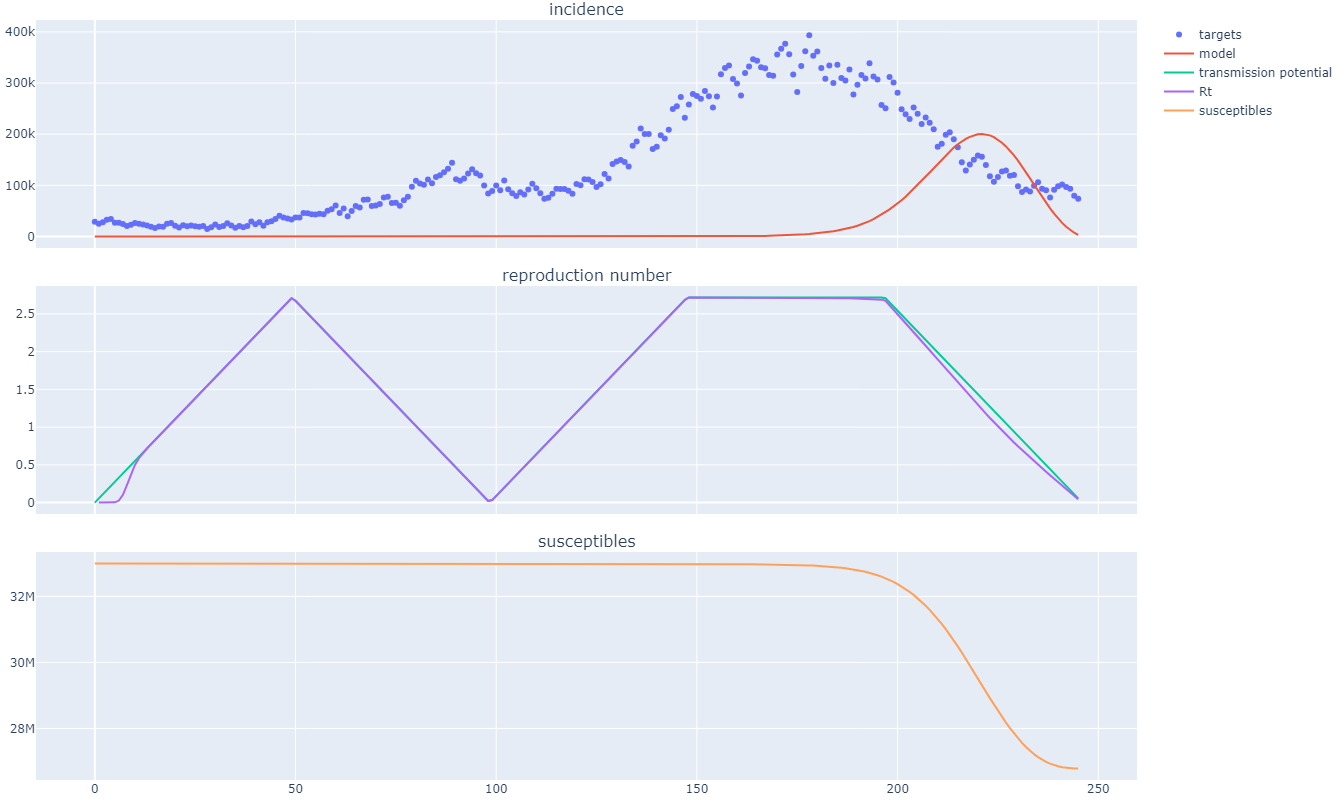

In [15]:
plot_output_fit(mys_data, model_result, process_vals, n_times)